## Tast 2: Download the model

In [79]:
import tensorflow as tf 
import random
import matplotlib.pyplot as plt

In [80]:
tf.__version__

'2.8.0'

In [81]:
model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3)
)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

## Task 3: Get Layer Output

In [82]:
def get_submodel(layer_name):
    return tf.keras.models.Model(
        model.input,
        model.get_layer(layer_name).output
    )

In [83]:

get_submodel('block1_conv2').summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Task 4: Image Visualization

In [84]:
def create_image():
    return tf.random.uniform((96, 96), minval=-0.5, maxval=0.5)

In [85]:
def plot_image(image, title='random'):
    image = image - tf.math.reduce_min(image)
    image = image / tf.math.reduce_max(image)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

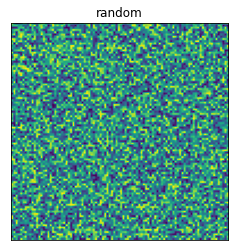

In [86]:
image = create_image()
plot_image(image)

## Task 5: Training Loop

In [87]:
def visualize_filter(layer_name, lr=20, iters=50, f_index=None):
    submodel = get_submodel(layer_name)
    
    num_filters = submodel.output.shape[-1]

    if not f_index:
        f_index = random.randint(0, num_filters - 1)
    
    assert num_filters > f_index, f'f_index ({f_index}) >= num_filters ({num_filters})'

    print(f'Maximizing image for layer {layer_name} and filter {f_index}')

    image = tf.random.uniform((96, 96, 3), minval=-0.5, maxval=0.5)
    verbose_step = int(iters / 10)

    for i in range(0, iters):
        with tf.GradientTape() as tape:
            tape.watch(image)
            output = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
            loss = tf.math.reduce_mean(output)
        grads = tape.gradient(loss, image)
        grads = tf.math.l2_normalize(grads)
        image += grads * lr
        
        if (i+1)%verbose_step  ==  0:
            print(f'Iteration: {i+1}, Loss: {loss.numpy():.4f}')

    plot_image(image, f'{layer_name} ({f_index})')

## Task 6: Final Results